In [1]:
import numpy as np

import json
import pandas as pd

In [2]:
import osmnx as ox
import networkx as nx

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [4]:
import random

In [5]:
from bike_service import *

# Información de las estaciones

Buscando en los archivos que https://www.ecobici.cdmx.gob.mx/es/mapa-de-cicloestaciones necesita, encontramos el archivo getJsonObject.json que contiene la información de todas las estaciones de Ecobici. Lo renombramos ecobici_stations.json, lo leemos y lo modificamos un poco.

In [6]:
ecobici_stations = pd.read_json("ecobici_stations.json")

In [7]:
ecobici_stations.set_index('id', inplace=True)

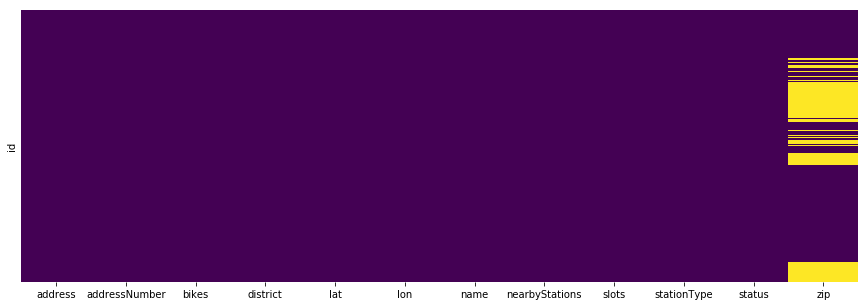

In [8]:
plt.figure(figsize=(15,5))
sns.heatmap(ecobici_stations.isnull(), yticklabels=False, cbar = False, cmap = 'viridis')

# Mapa de las delegaciones en que existe la red de Ecobici

La red de Ecobici abarca sólo unas cuantas delegaciones de la CDMX: Cuauhtémoc, Benito Juárez y Miguel Hidalgo. Entonces le pedimos a OpenStreetMap a través de osmnx que nos muestre únicamente el mapa de esas delegaciones.

In [9]:
# delegaciones en las que hay cobertura de ECOBICI.
delegaciones = ['Cuauhtemoc, Mexico City, Mexico',
                'Benito Juárez, Mexico City, Mexico',
                'Miguel Hidalgo, Mexico City, Mexico']
#ecobici_zone = ox.graph_from_place(delegaciones)

# Viajes

In [10]:
travels = pd.read_csv('2018-09.csv')

Cargamos los nodos más cercanos a cada una de las estaciones como las únicas ubicaciones aproximadas que osmnx le puede asignar a las estaciones.

In [11]:
travels.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo
0,M,72,4025,401,01/09/2018,0:00:03,158,01/09/2018,0:43:22
1,M,30,9367,72,01/09/2018,0:00:11,233,01/09/2018,0:23:41
2,M,29,10220,35,01/09/2018,0:00:22,299,01/09/2018,0:19:33
3,M,26,10619,86,01/09/2018,0:00:25,470,01/09/2018,0:10:52
4,M,21,3882,185,01/09/2018,0:00:28,188,01/09/2018,0:07:22


In [12]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701049 entries, 0 to 701048
Data columns (total 9 columns):
Genero_Usuario           701049 non-null object
Edad_Usuario             701049 non-null int64
Bici                     701049 non-null int64
Ciclo_Estacion_Retiro    701049 non-null int64
Fecha_Retiro             701049 non-null object
Hora_Retiro              701049 non-null object
Ciclo_Estacion_Arribo    701049 non-null int64
Fecha_Arribo             701049 non-null object
Hora_Arribo              701049 non-null object
dtypes: int64(4), object(5)
memory usage: 48.1+ MB


In [13]:
travels['Genero_Usuario'] = travels.Genero_Usuario.astype('category')

Eliminamos información erronea

In [14]:
no_stations = len(ecobici_stations)
no_stations

480

In [15]:
travels.drop(travels[travels['Ciclo_Estacion_Arribo'] > no_stations].index, inplace=True)
travels.drop(travels[travels['Ciclo_Estacion_Retiro'] > no_stations].index, inplace=True)

In [16]:
travels['Fecha_Hora_Arribo'] = pd.to_datetime(travels['Fecha_Arribo'] + ' ' + travels['Hora_Arribo'], dayfirst= True)
travels['Fecha_Hora_Retiro'] = pd.to_datetime(travels['Fecha_Retiro'] + ' ' + travels['Hora_Retiro'], dayfirst= True)

In [17]:
travels['Tiempo_Transcurrido']  = (travels['Fecha_Hora_Arribo'] - travels['Fecha_Hora_Retiro']).astype('timedelta64[s]')

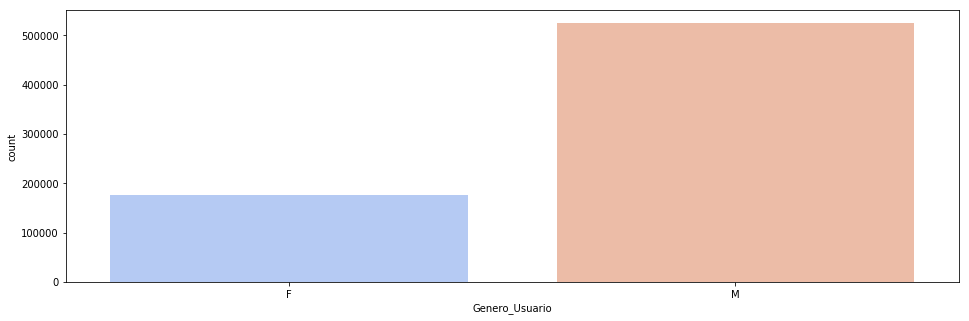

In [18]:
plt.figure(figsize=(16,5))
sns.countplot(travels['Genero_Usuario'], palette='coolwarm')

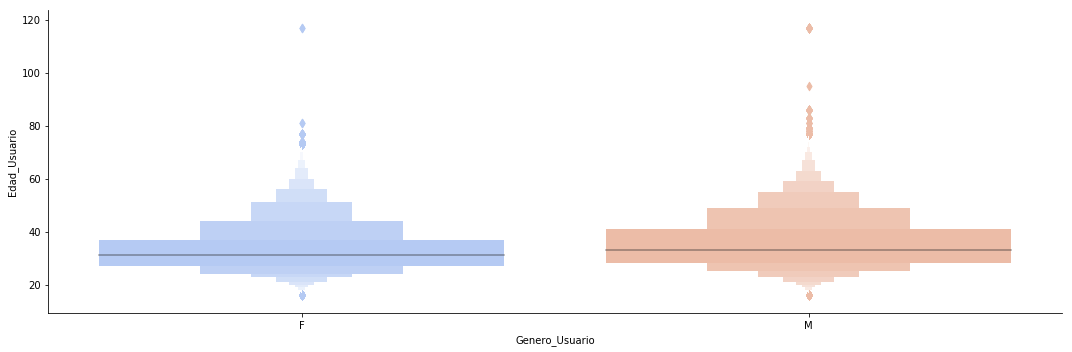

In [19]:
sns.catplot(x = 'Genero_Usuario', y = 'Edad_Usuario', data = travels, 
            height = 5, aspect=3, kind = 'boxen', palette = 'coolwarm')

In [20]:
travels.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Fecha_Hora_Arribo,Fecha_Hora_Retiro,Tiempo_Transcurrido
0,M,72,4025,401,01/09/2018,0:00:03,158,01/09/2018,0:43:22,2018-09-01 00:43:22,2018-09-01 00:00:03,2599.0
1,M,30,9367,72,01/09/2018,0:00:11,233,01/09/2018,0:23:41,2018-09-01 00:23:41,2018-09-01 00:00:11,1410.0
2,M,29,10220,35,01/09/2018,0:00:22,299,01/09/2018,0:19:33,2018-09-01 00:19:33,2018-09-01 00:00:22,1151.0
3,M,26,10619,86,01/09/2018,0:00:25,470,01/09/2018,0:10:52,2018-09-01 00:10:52,2018-09-01 00:00:25,627.0
4,M,21,3882,185,01/09/2018,0:00:28,188,01/09/2018,0:07:22,2018-09-01 00:07:22,2018-09-01 00:00:28,414.0


In [21]:
travels['Tiempo_Transcurrido'].mean()

930.8329940323931

In [22]:
ecobici_service = BikeService('ecobici', delegaciones, ecobici_stations, travels)

In [23]:
time_window = 24*3600

In [24]:
ecobici_use = ecobici_service.activity_ts('2018-09-01 04:00:00', '2018-09-30 04:00:00', time_window=time_window)

/home/pedro/git_repositories/ecobici_analysis/bike_service.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  take_df['time_units'] = (take_df['Fecha_Hora_Retiro'] - initial_date).astype('timedelta64[s]') // time_window
/home/pedro/git_repositories/ecobici_analysis/bike_service.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lock_df['time_units'] = (lock_df['Fecha_Hora_Arribo'] - initial_date).astype('timedelta64[s]') // time_window


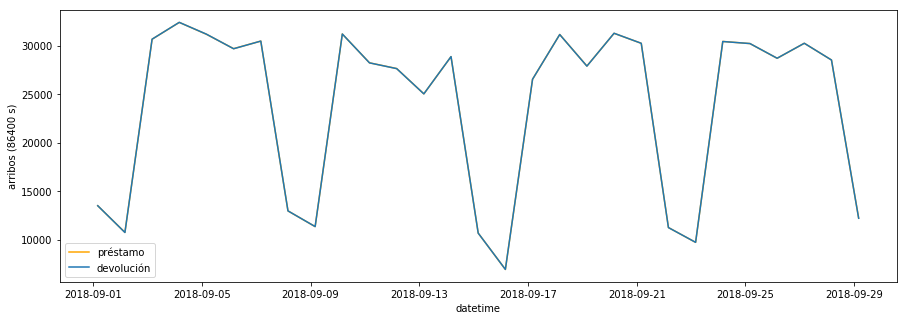

In [25]:
plt.figure(figsize = (15,5))
sns.lineplot(x = ecobici_use['take']['datetime'], 
             y = ecobici_use['take']['retiros (' + str(time_window) + ' s)'], color='orange', label = 'préstamo')
sns.lineplot(x = ecobici_use['lock']['datetime'],
             y = ecobici_use['lock']['arribos (' + str(time_window) + ' s)'], label = 'devolución')
plt.legend()

In [26]:
station_use = ecobici_service.station(50).activity_ts('2018-09-01 04:00:00', '2018-09-30 04:00:00', time_window=time_window)

/home/pedro/git_repositories/ecobici_analysis/bike_service.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  take_df['time_units'] = (take_df['Fecha_Hora_Retiro'] - initial_date).astype('timedelta64[s]')//time_window
/home/pedro/git_repositories/ecobici_analysis/bike_service.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lock_df['time_units'] = (lock_df['Fecha_Hora_Arribo'] - initial_date).astype('timedelta64[s]')//time_window


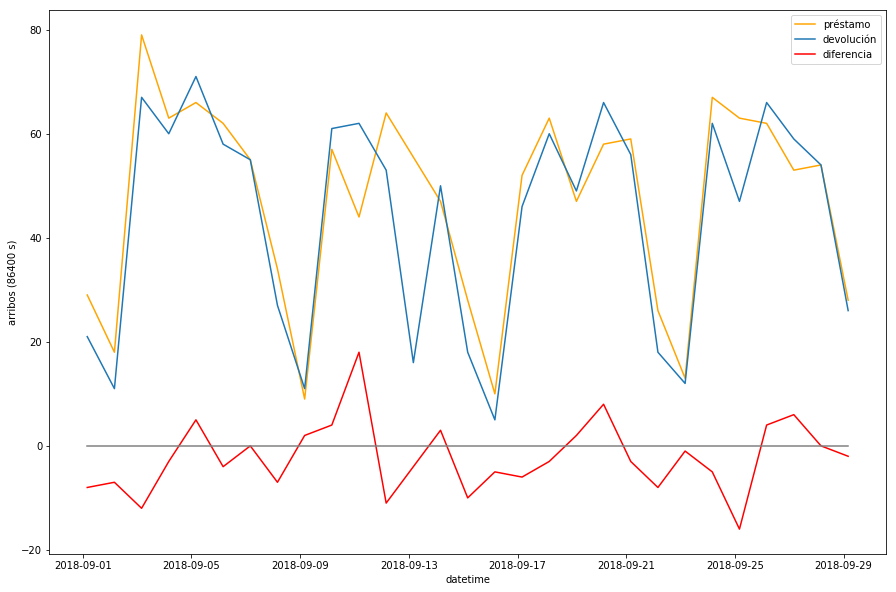

In [27]:
fig, ax = plt.subplots(figsize = (15,10))
sns.lineplot(x = station_use['take']['datetime'], 
             y = station_use['take']['retiros (' + str(time_window) + ' s)'], color='orange', label = 'préstamo')
sns.lineplot(x = station_use['lock']['datetime'], 
             y = station_use['lock']['arribos (' + str(time_window) + ' s)'], label = 'devolución')
sns.lineplot(x = station_use['lock']['datetime'], 
             y = station_use['lock']['arribos (' + str(time_window) + ' s)']
             - station_use['take']['retiros (' + str(time_window) + ' s)'], label = 'diferencia', color = 'r')
sns.lineplot(x = station_use['lock']['datetime'], y = 0, markers = 'o', color = 'gray')
plt.legend()

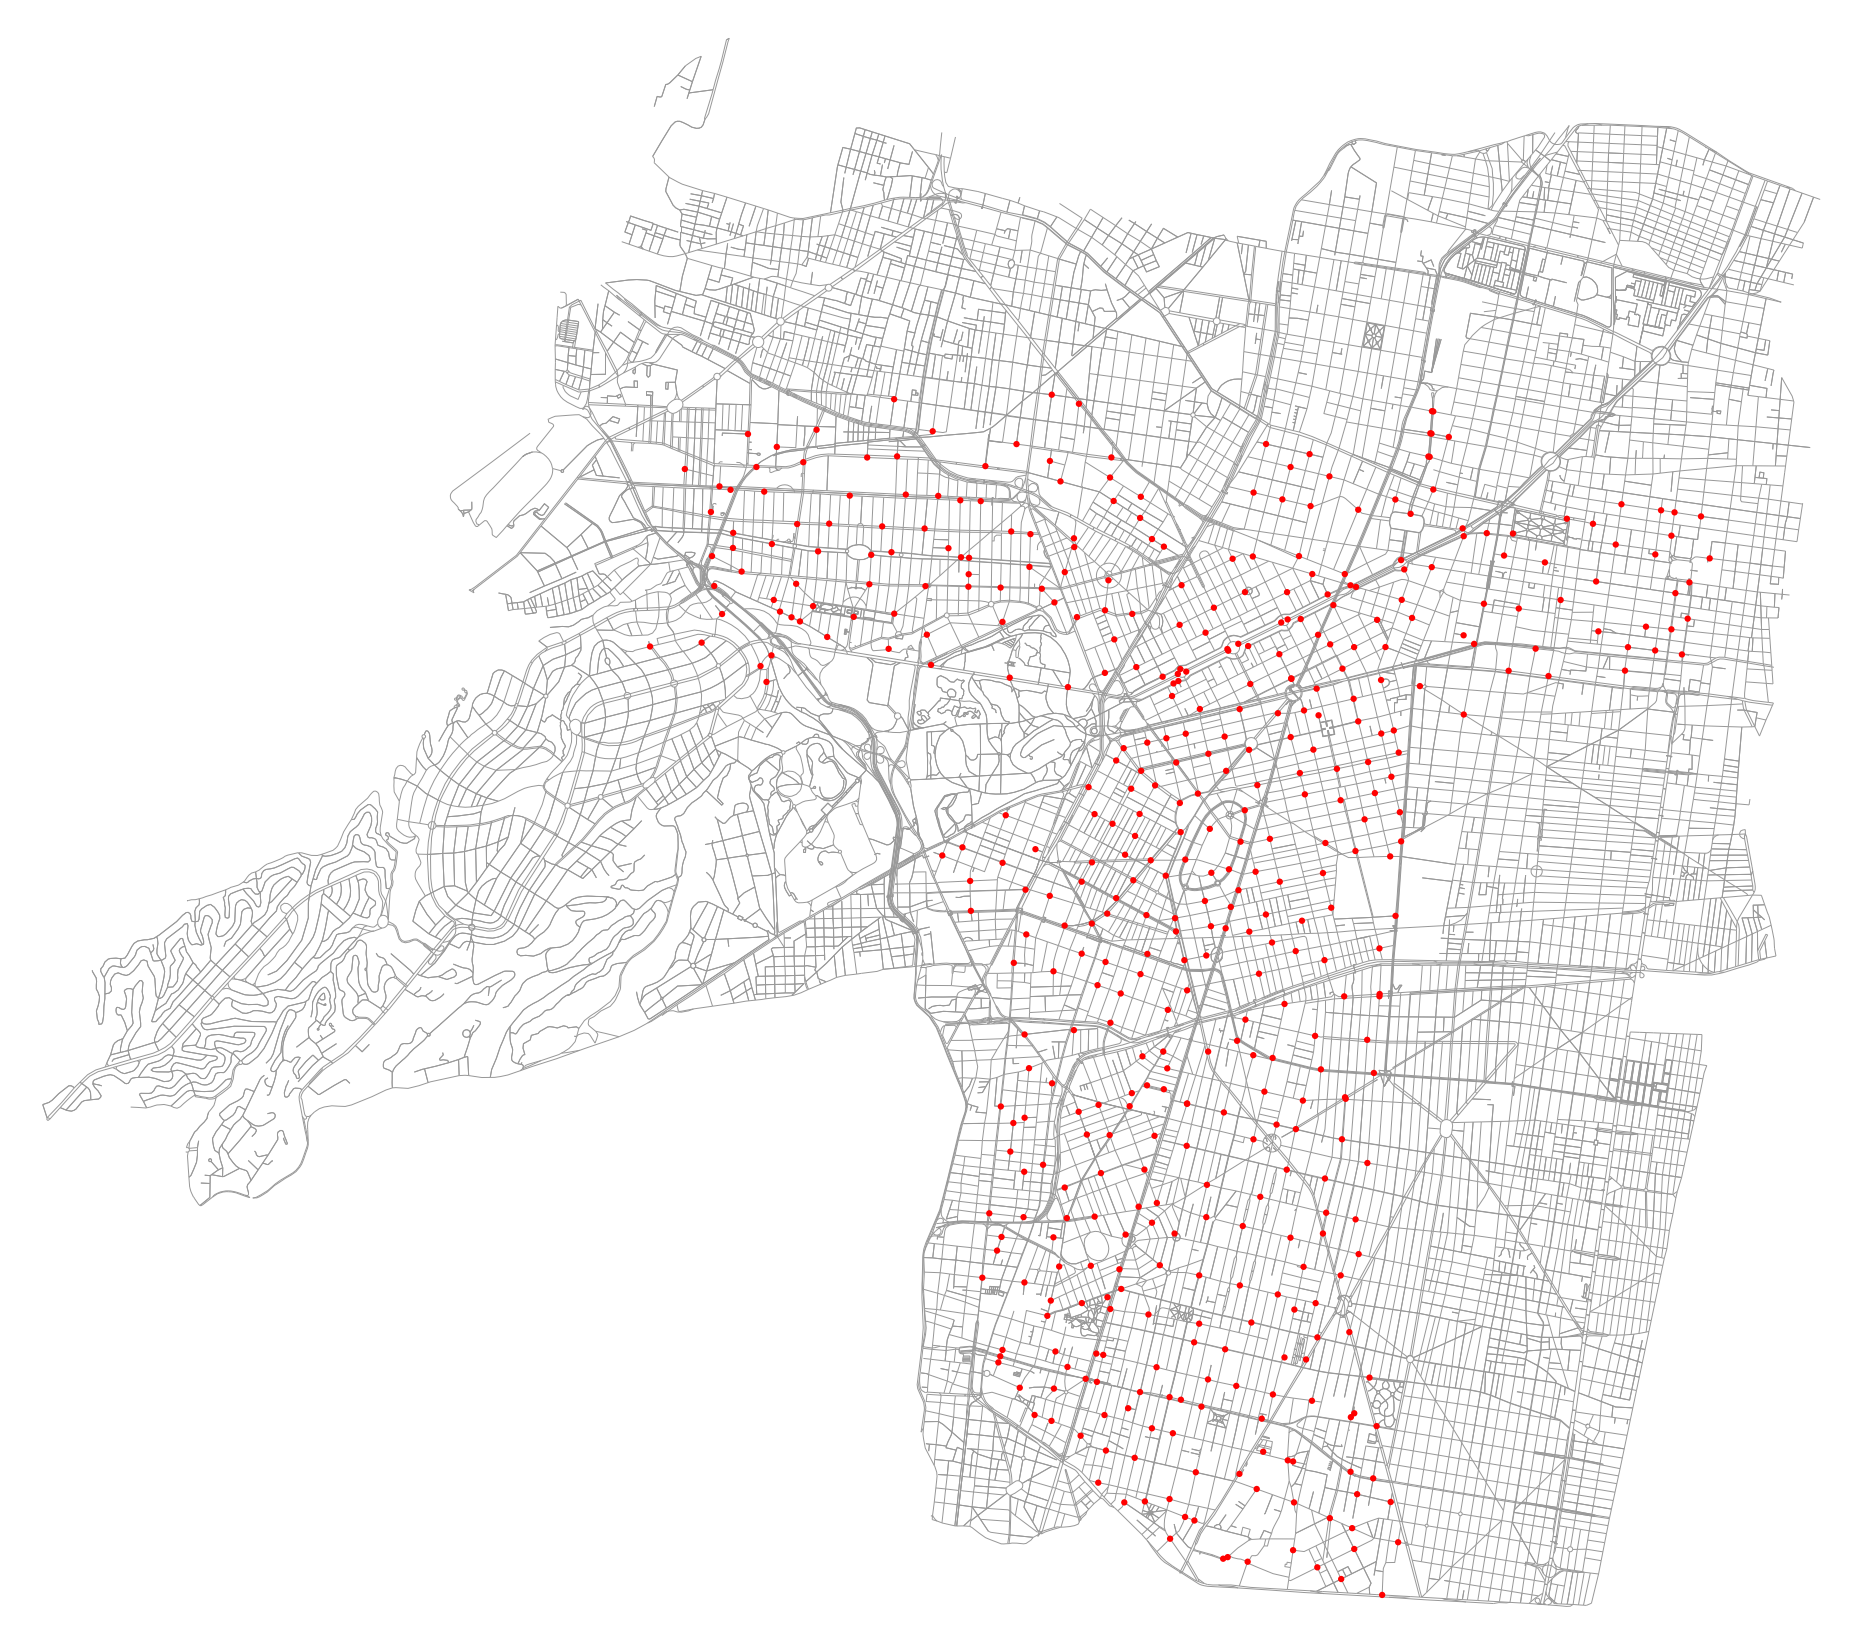

In [28]:
ecobici_service.map()

In [29]:
straight_distances = ecobici_service.stations_distances('straight')
street_distances = ecobici_service.stations_distances('street')

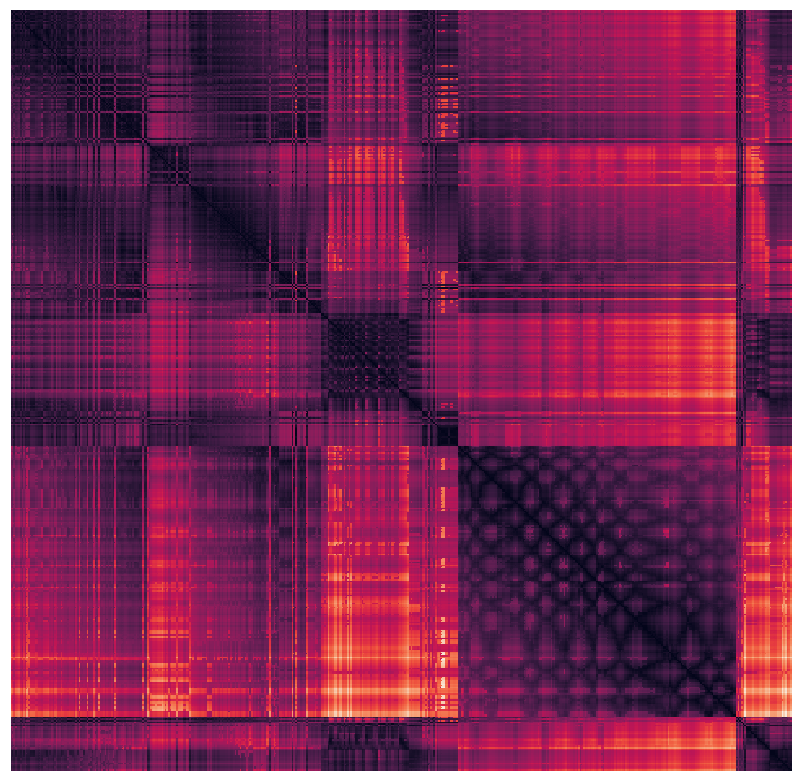

In [30]:
plt.figure(figsize=(14,14))
sns.heatmap(street_distances, xticklabels=False, yticklabels=False, cbar = False)

In [31]:
straight_distances_indices = [val[0] for val in sorted(enumerate(straight_distances[0,:]), key = lambda x: x[1])]
straight_distances_sorted = [straight_distances[0,:][index] for index in straight_distances_indices]
street_distances_from_sorted = [street_distances[0,:][index] for index in straight_distances_indices]
street_distances_to_sorted = [street_distances[:,0][index] for index in straight_distances_indices]

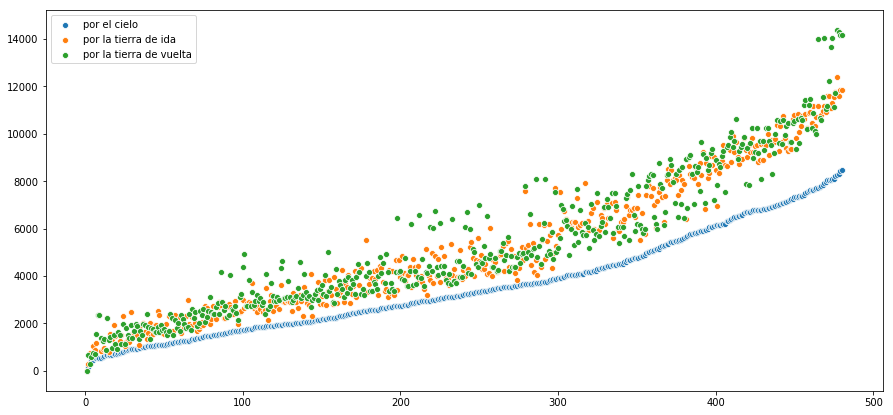

In [32]:
plt.figure(figsize = (15,7))

sns.scatterplot(np.arange(1,ecobici_service.size+1), straight_distances_sorted, label = 'por el cielo')
sns.scatterplot(np.arange(1,ecobici_service.size+1), street_distances_from_sorted, label = 'por la tierra de ida')
sns.scatterplot(np.arange(1,ecobici_service.size+1), street_distances_to_sorted, label = 'por la tierra de vuelta')
plt.legend()

In [33]:
ecobici_service.station(1).connections_subgraph()

El tiempo máximo de uso es 45 minutos (2700 segundos)

/home/pedro/anaconda3/envs/osmnx/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


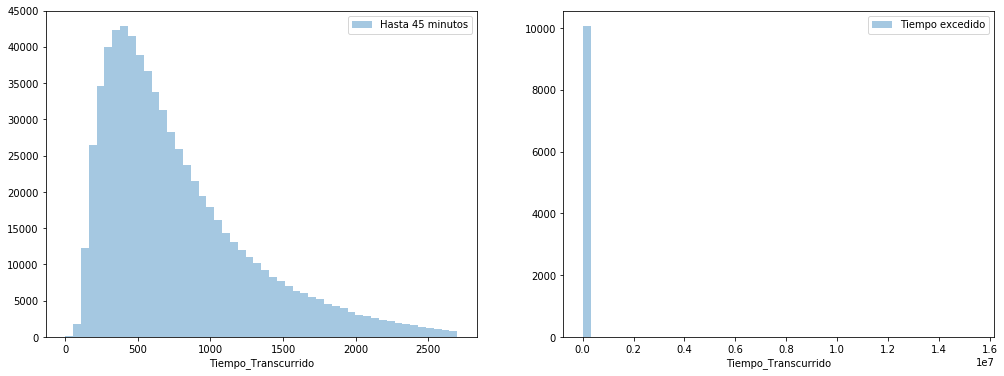

In [34]:
f, ax = plt.subplots(1, 2, figsize=(17, 6))
sns.distplot(travels['Tiempo_Transcurrido'], kde=False, rug=False, ax=ax[0],
             hist_kws={"range": [0,2700]}, label = 'Hasta 45 minutos')
plt.legend()
sns.distplot(travels['Tiempo_Transcurrido'], kde=False, rug=False, ax=ax[1],
             hist_kws={"range": [2700,travels['Tiempo_Transcurrido'].max()]}, label = 'Tiempo excedido')
ax[0].legend()
ax[1].legend()

In [37]:
ecobici_sample = ecobici_service.graph_nodes
ecobici_sample

0         276070400
1         275513347
2         275513349
3         268861478
4         268861479
5         276070440
6         275513397
7         270467134
8         338886719
9         270467136
10        270467137
11        270467138
12        275513410
13        275513411
14       1005060165
15        275513413
16        275513412
17        270467144
18        275513422
19        275513426
20        275677269
21        275677270
22        275677271
23        275677272
24        275513436
25        275513437
26       5832540258
27       5832540259
28       5832540260
29       5832540261
            ...    
16153     275677079
16154    3967549343
16155    3967549344
16156     275677080
16157     275677082
16158     275513275
16159     275709884
16160     276070334
16161     345210816
16162     276070341
16163     345210821
16164     271581127
16165     271581128
16166     270106571
16167     268861390
16168     270106575
16169     275513294
16170     275513297
16171     270106578


In [38]:
distances = np.zeros((ecobici_sample.shape[0], ecobici_service.size))
for index in np.arange(ecobici_sample.shape[0]):
    if index % 100 == 0:
        print(index)
    for destination_id in range(1, ecobici_service.size + 1):
        origin_node = ecobici_sample.iloc[index]
        destination_node = ecobici_service.network_df.loc[destination_id]['node']
        try:
            route = nx.shortest_path(ecobici_service.location_graph, origin_node, destination_node)
            distances[index, destination_id - 1] = sum([ecobici_service.location_graph.get_edge_data(u, v)[0]['length'] 
                                                                for u,v in zip(route, route[1:])])
        except:
            distances[index, destination_id - 1] = np.nan

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100


In [39]:
mask = np.all(np.isnan(distances), axis=1)
ecobici_sample = ecobici_sample[~mask]
distances = distances[~mask]

In [54]:
min_distances = np.nanmin(distances, axis = 1)

In [40]:
closest_stations = np.nanargmin(distances,axis = 1)

In [55]:
voronoi_df = pd.concat([pd.Series(ecobici_sample, index = ecobici_sample.index, name = 'node'),
                        pd.Series(closest_stations, index = ecobici_sample.index, name = 'nearest station'),
                        pd.Series(min_distances, index = ecobici_sample.index, name = 'distances')],
                       axis = 1)

In [56]:
voronoi_df.to_csv('data/voronoi_df.csv')

In [48]:
number_of_colors = ecobici_service.size

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

nc = ['gray'] * len(ecobici_service.graph_nodes)
for index, node in enumerate(ecobici_sample):
    node_index = ecobici_service.graph_nodes[ecobici_service.graph_nodes == node].index[0]
    nc[node_index] = color[closest_stations[index]]
#ns = np.where(ecobici_service.graph_nodes.isin(ecobici_sample), 40, 0)

In [ ]:
fig, ax = ox.plot_graph(ecobici_service.location_graph, fig_height=100, node_size=100, node_color=nc, 
                        node_zorder=2, edge_alpha=0.5, save = True)
Image('{}/{}.{}'.format('data','voronoi','png'), height=1000, width=1000)

In [57]:
voronoi_groups = voronoi_df.groupby('nearest station')

In [ ]:
for group in voronoi_groups:
    for node_i in group[1]['node'][0:]:
        for node_f in group[1]['node'][0:]:
            edge = ecobici_service.location_graph.get_edge_data(node_i,node_f)
            if edge:
                print(ecobici_service.location_graph.get_edge_data(node_i,node_f))

In [ ]:
for group in voronoi_groups:
    [ecobici_service.location_graph.get_edge_data(u,v) for u,v in groups]

In [ ]:
ec = ['white' for egde in ecobici_service.location_graph.edges()]
for group in voronoi_groups:
    if len(group[1]) > 1:

In [ ]:
nc = ['gray'] * len(ecobici_service.graph_nodes)
for index, node in enumerate(ecobici_sample):
    node_index = ecobici_service.graph_nodes[ecobici_service.graph_nodes == node].index[0]
    nc[node_index] = color[closest_stations[index]]
ns = np.where(ecobici_service.graph_nodes.isin(ecobici_sample), 40, 0)

ox.plot_graph(ecobici_service.location_graph, fig_height=30, node_size=ns,
              node_color=nc, node_zorder=2, edge_alpha=0.5, edge_color = ec)

In [ ]:
(276070400, 276074545) in ecobici_service.location_graph.edges()

In [ ]:
[self.location_graph.get_edge_data(u, v)[0]['length'] for u,v in zip(route, route[1:])]